In [1]:
# 0. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 0.1 全局路径配置（按你自己的文件名改）
DATA_DIR = Path("./Q1data")

CALENDAR_PATH = DATA_DIR / "20250615-London-calendar.csv"
LISTINGS_PATH = DATA_DIR / "20250615-London-listings.csv"

# 这里是刚才那个 Borough 租金 Excel（第一张截图那种，按 Borough）
RENT_EXCEL_PATH = DATA_DIR / "borough_rent_2024_07_2025_06.xlsx"

# 可选：住房存量 Excel（第三张截图），暂时可以不用
STOCK_EXCEL_PATH = DATA_DIR / "dwelling_stock_2024.xlsx"

# 商业化阈值
COMMERCIAL_AVAIL_THRESHOLD = 60   # available_nights > 60 = commercial STR
HOTEL_LIKE_OCC_THRESHOLD = 180    # occupied_nights > 180 = hotel-like

YEAR = 2024061520250614  # 只是打印提示用

# 画图样式
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

In [2]:
# 1.1 汇总 calendar → 每个 listing 的年度夜数
def summarise_calendar_streaming(path: Path,
                                 chunk_size: int = 200_000) -> pd.DataFrame:
    """
    流式读取大 calendar.csv，按 listing_id 汇总：
      - occupied_nights: 被占用夜数（available = 'f'）
      - total_nights: 有记录的总夜数
      - available_nights: total - occupied
      - occupancy_rate: occupied / total

    这里默认：calendar 文件的时间范围 ≈ 你要分析的年度。
    """
    agg = {}

    for chunk in pd.read_csv(
        path,
        usecols=["listing_id", "date", "available"],
        chunksize=chunk_size
    ):
        chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce")
        # available: 't' = available, 'f' = booked
        chunk["occupied"] = chunk["available"].map({"t": 0, "f": 1})

        grouped = chunk.groupby("listing_id")["occupied"].agg(
            occupied_nights="sum",
            total_nights="size"
        )

        for lid, row in grouped.iterrows():
            occ = int(row["occupied_nights"])
            tot = int(row["total_nights"])
            if lid in agg:
                prev_occ, prev_tot = agg[lid]
                agg[lid] = [prev_occ + occ, prev_tot + tot]
            else:
                agg[lid] = [occ, tot]

    summary = (
        pd.DataFrame
        .from_dict(agg, orient="index", columns=["occupied_nights", "total_nights"])
        .reset_index()
        .rename(columns={"index": "listing_id"})
    )

    summary["available_nights"] = summary["total_nights"] - summary["occupied_nights"]
    summary["occupancy_rate"] = summary["occupied_nights"] / summary["total_nights"]
    return summary


In [3]:
# 1.2 读取 listings & 清理 price
def load_listings(path: Path) -> pd.DataFrame:
    """
    读取 listings.csv，并把 price 清成数值 price_clean。
    """
    df = pd.read_csv(path, low_memory=False)

    if "price" in df.columns:
        df["price_clean"] = (
            df["price"]
            .astype(str)
            .str.replace("[$,£]", "", regex=True)
            .replace("", np.nan)
            .astype(float)
        )
    else:
        df["price_clean"] = np.nan

    return df


In [4]:
# 1.3 合并 calendar + listings
def merge_calendar_listings(occ_summary: pd.DataFrame,
                            listings: pd.DataFrame) -> pd.DataFrame:
    """
    把每个 listing 的年度夜数与房源属性、房东信息合并。
    """
    cols_to_keep = [
        "id", "host_id", "room_type",
        "neighbourhood_cleansed",
        "neighbourhood_group_cleansed",  # 当作 borough 用
        "latitude", "longitude",
        "number_of_reviews",
        "price_clean"
    ]
    cols_to_keep = [c for c in cols_to_keep if c in listings.columns]

    merged = occ_summary.merge(
        listings[cols_to_keep],
        left_on="listing_id",
        right_on="id",
        how="left"
    )
    return merged


In [5]:
# 1.4 添加商业化相关 flag
def add_commercialisation_flags(df: pd.DataFrame,
                                commercial_avail: int = 60,
                                hotel_like_occ: int = 180) -> pd.DataFrame:
    """
    添加：
      - is_entire_home
      - commercial_STR: available_nights > 60
      - hotel_like: occupied_nights > 180
      - legal_but_commercial: 如果之前已经有 violates_90day，就顺带标一列
    """
    df = df.copy()
    df["is_entire_home"] = df["room_type"].eq("Entire home/apt")
    df["commercial_STR"] = df["available_nights"] > commercial_avail
    df["hotel_like"] = df["occupied_nights"] > hotel_like_occ

    if "violates_90day" in df.columns:
        df["legal_but_commercial"] = (~df["violates_90day"]) & df["commercial_STR"]
    else:
        df["legal_but_commercial"] = np.nan

    return df

In [6]:
#2. Entire-home share
def compute_entire_home_stats(df: pd.DataFrame) -> dict:
    """
    计算：
      - 全市 entire-home 占比
      - 按 borough（neighbourhood_group_cleansed）占比
    """
    stats = {}
    mask_valid = df["room_type"].notna()
    total_listings = mask_valid.sum()

    entire = df["room_type"].eq("Entire home/apt")
    n_entire = entire.sum()
    share_entire = n_entire / total_listings if total_listings > 0 else np.nan

    stats["total_listings"] = int(total_listings)
    stats["n_entire"] = int(n_entire)
    stats["share_entire"] = share_entire

    if "neighbourhood_group_cleansed" in df.columns:
        by_borough = (
            df[mask_valid]
            .groupby("neighbourhood_group_cleansed")["room_type"]
            .agg(
                n_listings="count",
                n_entire=lambda s: (s == "Entire home/apt").sum()
            )
            .reset_index()
            .rename(columns={"neighbourhood_group_cleansed": "borough"})
        )
        by_borough["share_entire"] = by_borough["n_entire"] / by_borough["n_listings"]
        stats["by_borough"] = by_borough
    else:
        stats["by_borough"] = None

    return stats


In [7]:
#3. Host structure（multi-listing / 专业房东）
def compute_host_structure(df: pd.DataFrame) -> dict:
    """
    计算市场结构：
      - 每个 host 拥有多少 listing
      - multi-host（>=2） share
      - multi-host 控制的 listing 占比
      - top 10%、1% host 控制 listing 的占比
    """
    valid = df["host_id"].notna()
    host_counts = (
        df[valid]
        .groupby("host_id")["listing_id"]
        .nunique()
        .sort_values(ascending=False)
    )

    total_hosts = host_counts.shape[0]
    total_listings = df["listing_id"].nunique()

    multi_host = host_counts[host_counts >= 2]
    n_multi_hosts = multi_host.shape[0]
    listing_by_multi = df[df["host_id"].isin(multi_host.index)]["listing_id"].nunique()

    def top_fraction_share(h_counts, fraction):
        n_top = max(1, int(len(h_counts) * fraction))
        top_hosts = h_counts.head(n_top).index
        n_listings_top = df[df["host_id"].isin(top_hosts)]["listing_id"].nunique()
        return n_listings_top / total_listings if total_listings > 0 else np.nan

    top10_share = top_fraction_share(host_counts, 0.10)
    top1_share = top_fraction_share(host_counts, 0.01)

    stats = {
        "total_hosts": int(total_hosts),
        "total_listings": int(total_listings),
        "n_multi_hosts": int(n_multi_hosts),
        "share_multi_hosts": n_multi_hosts / total_hosts if total_hosts > 0 else np.nan,
        "listing_by_multi": int(listing_by_multi),
        "share_listing_by_multi": listing_by_multi / total_listings if total_listings > 0 else np.nan,
        "share_listing_top10pct_hosts": top10_share,
        "share_listing_top1pct_hosts": top1_share,
        "host_counts": host_counts,
    }
    return stats


In [8]:
#4,1 High availability / hotel-like & 商业化矩阵
def compute_availability_stats(df: pd.DataFrame) -> dict:
    """
    针对整套房：
      - commercial_STR 占比
      - hotel_like 占比
      - legal_but_commercial 占比（如有）
    """
    entire = df[df["is_entire_home"]].copy()
    n_entire = entire["listing_id"].nunique()

    commercial = entire["commercial_STR"].sum()
    hotel_like = entire["hotel_like"].sum()

    stats = {
        "n_entire": int(n_entire),
        "n_commercial_STR": int(commercial),
        "share_commercial_STR": commercial / n_entire if n_entire > 0 else np.nan,
        "n_hotel_like": int(hotel_like),
        "share_hotel_like": hotel_like / n_entire if n_entire > 0 else np.nan,
    }

    if "legal_but_commercial" in entire.columns:
        legal_but = entire["legal_but_commercial"].sum()
        stats["n_legal_but_commercial"] = int(legal_but)
        stats["share_legal_but_commercial"] = (
            legal_but / n_entire if n_entire > 0 else np.nan
        )

    return stats

In [9]:
#4.2hotel-like & 商业化矩阵
def compute_commercialisation_matrix(df: pd.DataFrame,
                                     host_structure_stats: dict) -> dict:
    """
    三个维度交叉：
      - is_entire_home
      - is_multi_host (>=2)
      - commercial_STR

    识别：
      - entire only
      - entire + multi-host
      - entire + commercial
      - entire + multi-host + commercial（准酒店运营者）
    """
    host_counts = host_structure_stats["host_counts"]
    multi_host_ids = host_counts[host_counts >= 2].index

    df = df.copy()
    df["is_multi_host"] = df["host_id"].isin(multi_host_ids)

    entire = df[df["is_entire_home"]].copy()
    n_entire = entire["listing_id"].nunique()

    def count_condition(mask):
        return entire[mask]["listing_id"].nunique()

    n_entire_only = count_condition(~entire["is_multi_host"] & ~entire["commercial_STR"])
    n_entire_multi = count_condition(entire["is_multi_host"] & ~entire["commercial_STR"])
    n_entire_commercial = count_condition(~entire["is_multi_host"] & entire["commercial_STR"])
    n_entire_multi_commercial = count_condition(entire["is_multi_host"] & entire["commercial_STR"])

    matrix = {
        "n_entire_total": int(n_entire),
        "n_entire_only": int(n_entire_only),
        "n_entire_multi": int(n_entire_multi),
        "n_entire_commercial": int(n_entire_commercial),
        "n_entire_multi_commercial": int(n_entire_multi_commercial),
    }

    for key in list(matrix.keys()):
        if key.startswith("n_") and key != "n_entire_total":
            share_key = key.replace("n_", "share_")
            matrix[share_key] = matrix[key] / n_entire if n_entire > 0 else np.nan

    return matrix


In [10]:
#5.1 估算每个 listing 的年收入 / 月收入
def compute_str_revenue(df: pd.DataFrame) -> pd.DataFrame:
    """
    估算 STR 收益：
      - str_revenue = price_clean * occupied_nights
      - monthly_str = str_revenue / 12
    """
    df = df.copy()
    if "price_clean" not in df.columns:
        df["price_clean"] = np.nan

    df["str_revenue"] = df["price_clean"] * df["occupied_nights"]
    df["monthly_str"] = df["str_revenue"] / 12.0
    return df


In [11]:
#5.2 从 Borough 租金 Excel 读出 median_rent
def load_borough_rents(path: Path,
                       bedroom_category: str = "Two Bedrooms",
                       sheet_name: int | str | None = 0) -> pd.DataFrame:
    """
    从 GLA Excel 中读取 Borough-level median rent。
    假设表头在第 3 行（'Borough', 'Bedroom Category', 'Median'）。

    返回列：
      - borough
      - median_rent
    """
    rent_raw = pd.read_excel(
        path,
        sheet_name=sheet_name,
        header=2  # 第 3 行是表头
    )

    cols = ["Borough", "Bedroom Category", "Median"]
    rent_raw = rent_raw[cols]

    rent_sel = rent_raw[rent_raw["Bedroom Category"] == bedroom_category].copy()
    rent_sel = rent_sel.dropna(subset=["Borough", "Median"])

    rent_sel = rent_sel.rename(columns={"Borough": "borough", "Median": "median_rent"})
    rent_sel["median_rent"] = pd.to_numeric(rent_sel["median_rent"], errors="coerce")
    rent_sel = rent_sel.dropna(subset=["median_rent"])

    return rent_sel


In [12]:
#5.3 按 borough 计算 STR 月收入中位数（只看整套 + commercial STR）
def summarise_str_income_by_borough(df: pd.DataFrame,
                                    area_col: str = "neighbourhood_group_cleansed",
                                    commercial_only: bool = True) -> pd.DataFrame:
    """
    按 borough 计算：
      - n_listings
      - median_str_monthly（STR 月收入中位数）
    """
    if area_col not in df.columns:
        raise ValueError(f"{area_col} not in DataFrame.")

    subset = df.copy()
    subset = subset[subset["is_entire_home"]]

    if commercial_only:
        subset = subset[subset["commercial_STR"]]

    subset = subset[subset["monthly_str"].notna()]

    grouped = (
        subset.groupby(area_col)
        .agg(
            n_listings=("listing_id", "nunique"),
            median_str_monthly=("monthly_str", "median")
        )
        .reset_index()
        .rename(columns={area_col: "borough"})
    )
    return grouped


In [13]:
#5.4 合并 STR 月收入 & LTR 租金 + 计算差额/比例
def merge_str_and_rent(str_borough: pd.DataFrame,
                       rent_borough: pd.DataFrame) -> pd.DataFrame:
    """
    合并：
      - median_str_monthly
      - median_rent
      - diff_str_minus_rent
      - ratio_str_to_rent
    """
    df = str_borough.merge(rent_borough, on="borough", how="inner").copy()
    df["diff_str_minus_rent"] = df["median_str_monthly"] - df["median_rent"]
    df["ratio_str_to_rent"] = df["median_str_monthly"] / df["median_rent"]

    df = df.sort_values("diff_str_minus_rent", ascending=False)
    return df


In [14]:
#6 STR density
def load_borough_stock(path: Path,
                       sheet_name: int | str | None = 0) -> pd.DataFrame:
    """
    从 Dwelling stock Excel 里读出：
      - borough
      - total dwellings

    假设表头在第 6 行（'Area', 'Total'）。
    """
    stock_raw = pd.read_excel(path, sheet_name=sheet_name, header=5)
    stock_sel = stock_raw[["Area", "Total"]].copy()
    stock_sel = stock_sel.rename(columns={"Area": "borough", "Total": "n_dwellings"})
    stock_sel = stock_sel.dropna(subset=["borough", "n_dwellings"])
    return stock_sel
def load_borough_stock(path: Path,
                       sheet_name: int | str | None = 0) -> pd.DataFrame:
    """
    从 Dwelling stock Excel 里读出：
      - borough
      - total dwellings

    假设表头在第 6 行（'Area', 'Total'）。
    """
    stock_raw = pd.read_excel(path, sheet_name=sheet_name, header=5)
    stock_sel = stock_raw[["Area", "Total"]].copy()
    stock_sel = stock_sel.rename(columns={"Area": "borough", "Total": "n_dwellings"})
    stock_sel = stock_sel.dropna(subset=["borough", "n_dwellings"])
    return stock_sel


In [15]:
def compute_str_density(df: pd.DataFrame,
                        stock_df: pd.DataFrame,
                        borough_col: str = "neighbourhood_group_cleansed") -> pd.DataFrame:
    """
    STR per 1,000 dwellings。
    """
    if borough_col not in df.columns:
        raise ValueError(f"{borough_col} not found in df.")

    listings_by_borough = (
        df.groupby(borough_col)["listing_id"]
        .nunique()
        .reset_index()
        .rename(columns={borough_col: "borough", "listing_id": "n_airbnb"})
    )

    merged = listings_by_borough.merge(stock_df, on="borough", how="left")
    merged["str_density_per_1000"] = merged["n_airbnb"] / merged["n_dwellings"] * 1000.0
    return merged


In [16]:
#7.1
def plot_host_distribution(host_structure_stats: dict):
    host_counts = host_structure_stats["host_counts"]
    plt.figure()
    host_counts.value_counts().sort_index().plot(kind="bar")
    plt.xlabel("Number of listings per host")
    plt.ylabel("Number of hosts")
    plt.title("Host size distribution (market structure)")
    plt.tight_layout()
    plt.show()


In [17]:
#7.2
def plot_availability_distribution(df: pd.DataFrame):
    entire = df[df["is_entire_home"]]
    plt.figure()
    plt.hist(entire["available_nights"].dropna(), bins=40)
    plt.xlabel("Available nights in year")
    plt.ylabel("Number of entire-home listings")
    plt.title("Distribution of annual availability (entire homes)")
    plt.tight_layout()
    plt.show()


In [18]:
#7.3
def plot_commercial_str_by_area(df: pd.DataFrame):
    """
    自动在 ['neighbourhood_group_cleansed', 'neighbourhood_cleansed'] 里
    找一个非空的列作为地理分组来画 commercial STR share。
    """
    # 1. 选一个有值的 area 列
    cand_cols = ["neighbourhood_group_cleansed", "neighbourhood_cleansed"]
    area_col = None
    for col in cand_cols:
        if col in df.columns and df[col].notna().any():
            area_col = col
            break

    if area_col is None:
        print("No valid area column found; skip plot.")
        return

    print(f"Using '{area_col}' as area column for commercial STR plot.")

    # 2. 只看整套房 + area 非空
    entire = df[df["is_entire_home"] & df[area_col].notna()].copy()

    if entire.empty:
        print("No entire-home listings with non-missing area; skip plot.")
        return

    # 3. 按 area 统计 commercial STR 占比
    grouped = (
        entire.groupby(area_col)["commercial_STR"]
        .agg(
            n_entire="size",
            n_commercial="sum"
        )
        .reset_index()
        .rename(columns={area_col: "area"})
    )

    grouped["share_commercial"] = grouped["n_commercial"] / grouped["n_entire"]

    # 排序
    grouped = grouped.sort_values("share_commercial", ascending=False)

    # 4. 画图
    plt.figure(figsize=(8, 6))
    plt.barh(grouped["area"], grouped["share_commercial"])
    plt.xlabel("Share of commercial STR (entire homes)")
    plt.ylabel("Area")
    plt.title("Commercial STR share by area")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [19]:
7.4 
def plot_str_vs_rent_borough(df: pd.DataFrame, top_n: int | None = None):
    """
    并列柱状图：每个 borough 的 STR 月收入 vs LTR 租金。
    """
    if top_n is not None:
        df = df.head(top_n)

    boroughs = df["borough"]
    x = np.arange(len(boroughs))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, df["median_str_monthly"], width, label="STR monthly (median)")
    plt.bar(x + width/2, df["median_rent"], width, label="LTR rent (median)")

    plt.xticks(x, boroughs, rotation=45, ha="right")
    plt.ylabel("Monthly amount (£)")
    plt.title("Estimated Airbnb STR monthly income vs long-term rent by borough")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [20]:
def plot_str_rent_diff_borough(df: pd.DataFrame, top_n: int | None = None):
    """
    差额柱状图：STR 月收入 - LTR 租金。
    """
    if top_n is not None:
        df = df.head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(df["borough"], df["diff_str_minus_rent"])
    plt.xlabel("Difference between STR monthly income and LTR rent (£)")
    plt.ylabel("Borough")
    plt.title("STR–LTR monthly income gap by borough")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [21]:
8
def run_commercial_analysis(load_rent: bool = True,
                            load_stock: bool = False):
    """
    一键执行“商业化 Part”的分析：
      1. 汇总 calendar
      2. 读 listings 并合并
      3. Entire-home share
      4. Host structure (multi-listing)
      5. High availability / hotel-like
      6. Commercialisation matrix
      7. STR revenue estimate
      8. STR vs LTR rent（如果 load_rent=True）
      9. 可选：STR density（load_stock=True）
      10. 绘图
    """
    print(f"=== Step 1: Calendar summary (approx. year {YEAR}) ===")
    occ_summary = summarise_calendar_streaming(CALENDAR_PATH)
    print("  Listings with calendar data:", len(occ_summary))

    print("=== Step 2: Load listings & merge ===")
    listings = load_listings(LISTINGS_PATH)
    merged = merge_calendar_listings(occ_summary, listings)
    merged = add_commercialisation_flags(
        merged,
        COMMERCIAL_AVAIL_THRESHOLD,
        HOTEL_LIKE_OCC_THRESHOLD
    )
    print("  Merged rows:", len(merged))

    print("=== Step 3: Entire-home statistics ===")
    entire_stats = compute_entire_home_stats(merged)
    print(f"  Entire-home share (city-wide): {entire_stats['share_entire']:.2%}")

    print("=== Step 4: Host structure ===")
    host_stats = compute_host_structure(merged)
    print(f"  Total hosts: {host_stats['total_hosts']}")
    print(f"  Multi-host share: {host_stats['share_multi_hosts']:.2%}")
    print(f"  Listings controlled by multi-hosts: {host_stats['share_listing_by_multi']:.2%}")
    print(f"  Listings controlled by top 10% hosts: {host_stats['share_listing_top10pct_hosts']:.2%}")
    print(f"  Listings controlled by top 1% hosts: {host_stats['share_listing_top1pct_hosts']:.2%}")

    print("=== Step 5: Availability & hotel-like STR ===")
    avail_stats = compute_availability_stats(merged)
    print(f"  Commercial STR share (entire homes): {avail_stats['share_commercial_STR']:.2%}")
    print(f"  Hotel-like STR share (entire homes): {avail_stats['share_hotel_like']:.2%}")
    if "share_legal_but_commercial" in avail_stats:
        val = avail_stats["share_legal_but_commercial"]
        if not np.isnan(val):
            print(f"  Legal but commercial (entire homes): {val:.2%}")

    print("=== Step 6: Commercialisation matrix ===")
    matrix_stats = compute_commercialisation_matrix(merged, host_stats)
    print(f"  Entire homes (total): {matrix_stats['n_entire_total']}")
    print(f"  Entire-only share: {matrix_stats['share_entire_only']:.2%}")
    print(f"  Entire + multi-host share: {matrix_stats['share_entire_multi']:.2%}")
    print(f"  Entire + commercial share: {matrix_stats['share_entire_commercial']:.2%}")
    print(f"  Entire + multi-host + commercial share: {matrix_stats['share_entire_multi_commercial']:.2%}")

    print("=== Step 7: STR revenue estimate ===")
    merged_with_rev = compute_str_revenue(merged)
    median_entire_monthly = (
        merged_with_rev[merged_with_rev["is_entire_home"]]["monthly_str"].median()
    )
    print(f"  Median monthly STR income (entire homes): £{median_entire_monthly:,.0f}")

    str_rent_borough = None
    if load_rent:
        try:
            print("=== Step 8: Load borough rents & compare STR vs LTR ===")
            rent_borough = load_borough_rents(RENT_EXCEL_PATH,
                                              bedroom_category="Two Bedrooms")
            str_borough = summarise_str_income_by_borough(
                merged_with_rev,
                area_col="neighbourhood_group_cleansed",
                commercial_only=True
            )
            str_rent_borough = merge_str_and_rent(str_borough, rent_borough)
            print("  STR vs LTR (first rows):")
            print(str_rent_borough.head())
        except FileNotFoundError:
            print("  RENT_EXCEL_PATH not found; skip STR vs LTR comparison.")

    str_density_df = None
    if load_stock:
        try:
            print("=== Step 9: STR density (optional) ===")
            stock_df = load_borough_stock(STOCK_EXCEL_PATH)
            str_density_df = compute_str_density(
                merged_with_rev,
                stock_df,
                borough_col="neighbourhood_group_cleansed"
            )
            print(str_density_df.head())
        except FileNotFoundError:
            print("  STOCK_EXCEL_PATH not found; skip STR density.")

    print("=== Step 10: Plots ===")
    plot_host_distribution(host_stats)
    plot_availability_distribution(merged_with_rev)
    plot_commercial_str_by_area(merged_with_rev)

    if str_rent_borough is not None:
        plot_str_vs_rent_borough(str_rent_borough)
        plot_str_rent_diff_borough(str_rent_borough, top_n=15)

    print("=== Commercialisation analysis done. ===")

    return {
        "occ_summary": occ_summary,
        "merged": merged_with_rev,
        "entire_stats": entire_stats,
        "host_stats": host_stats,
        "availability_stats": avail_stats,
        "commercial_matrix": matrix_stats,
        "str_rent_borough": str_rent_borough,
        "str_density": str_density_df,
    }


=== Step 1: Calendar summary (approx. year 2024061520250614) ===
  Listings with calendar data: 93480
=== Step 2: Load listings & merge ===
  Merged rows: 93480
=== Step 3: Entire-home statistics ===
  Entire-home share (city-wide): 61.19%
=== Step 4: Host structure ===
  Total hosts: 43329
  Multi-host share: 16.70%
  Listings controlled by multi-hosts: 31.51%
  Listings controlled by top 10% hosts: 25.30%
  Listings controlled by top 1% hosts: 10.63%
=== Step 5: Availability & hotel-like STR ===
  Commercial STR share (entire homes): 50.69%
  Hotel-like STR share (entire homes): 69.37%
  Legal but commercial (entire homes): 0.00%
=== Step 6: Commercialisation matrix ===
  Entire homes (total): 40112
  Entire-only share: 35.06%
  Entire + multi-host share: 14.25%
  Entire + commercial share: 19.76%
  Entire + multi-host + commercial share: 30.93%
=== Step 7: STR revenue estimate ===
  Median monthly STR income (entire homes): £2,495
=== Step 8: Load borough rents & compare STR vs LTR 

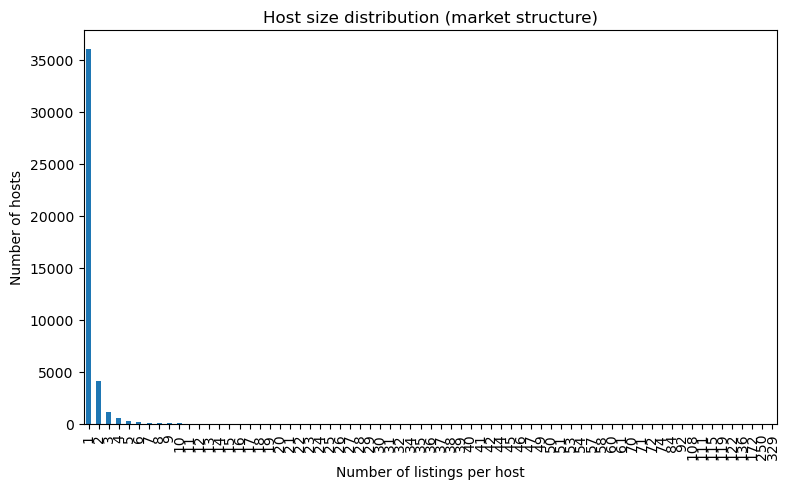

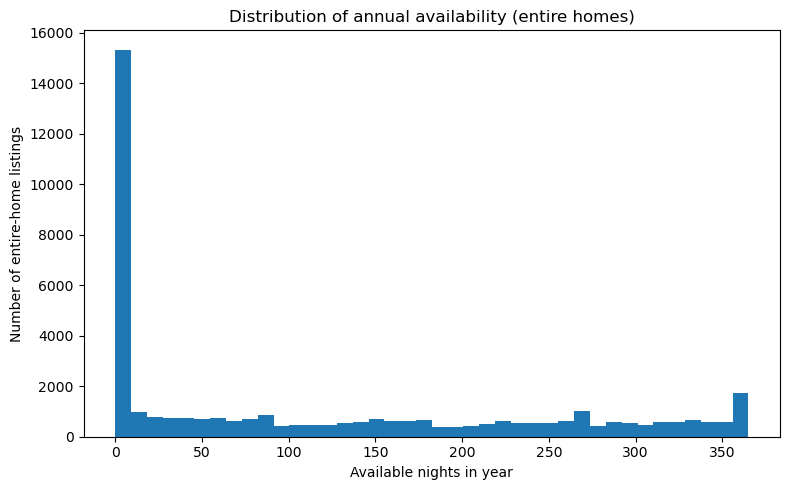

Using 'neighbourhood_cleansed' as area column for commercial STR plot.


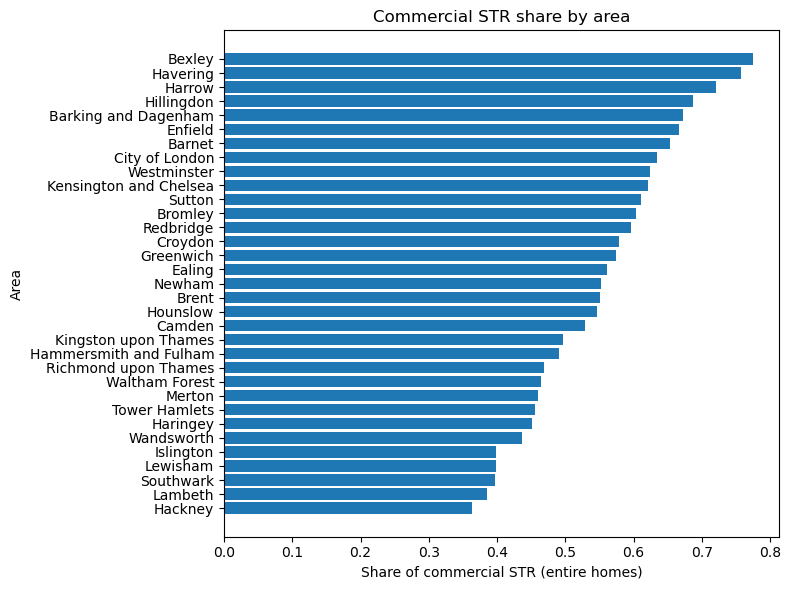

=== Commercialisation analysis done. ===


In [22]:
results_commercial = run_commercial_analysis(
    load_rent=True,    # 用 Excel 里的 Borough 租金做 STR vs LTR
    load_stock=True   # 暂时不算住房存量的话就 False
)


=== Step 1: Calendar summary (approx. year 2024061520250614) ===
  Listings with calendar data: 93480
=== Step 2: Load listings & merge ===
  Merged rows: 93480
=== Step 3: Entire-home statistics ===
  Entire-home share (city-wide): 61.19%
=== Step 4: Host structure ===
  Total hosts: 43329
  Multi-host share: 16.70%
  Listings controlled by multi-hosts: 31.51%
  Listings controlled by top 10% hosts: 25.30%
  Listings controlled by top 1% hosts: 10.63%
=== Step 5: Availability & hotel-like STR ===
  Commercial STR share (entire homes): 50.69%
  Hotel-like STR share (entire homes): 69.37%
  Legal but commercial (entire homes): 0.00%
=== Step 6: Commercialisation matrix ===
  Entire homes (total): 40112
  Entire-only share: 35.06%
  Entire + multi-host share: 14.25%
  Entire + commercial share: 19.76%
  Entire + multi-host + commercial share: 30.93%
=== Step 7: STR revenue estimate ===
  Median monthly STR income (entire homes): £2,495
=== Step 10: Plots ===


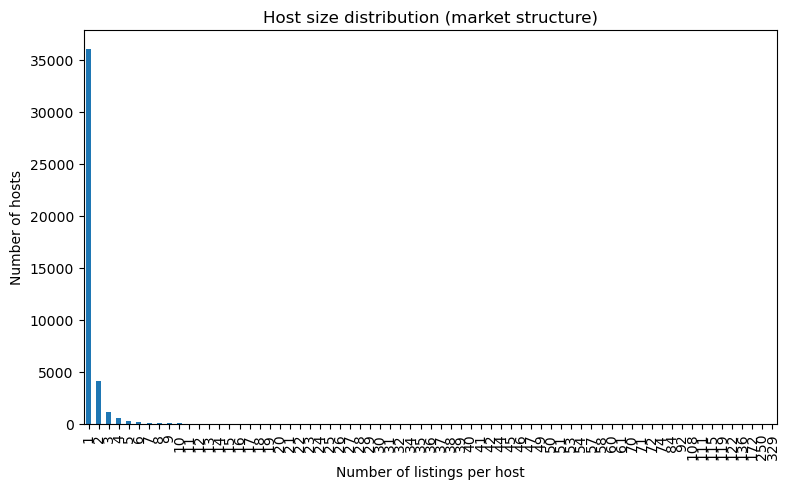

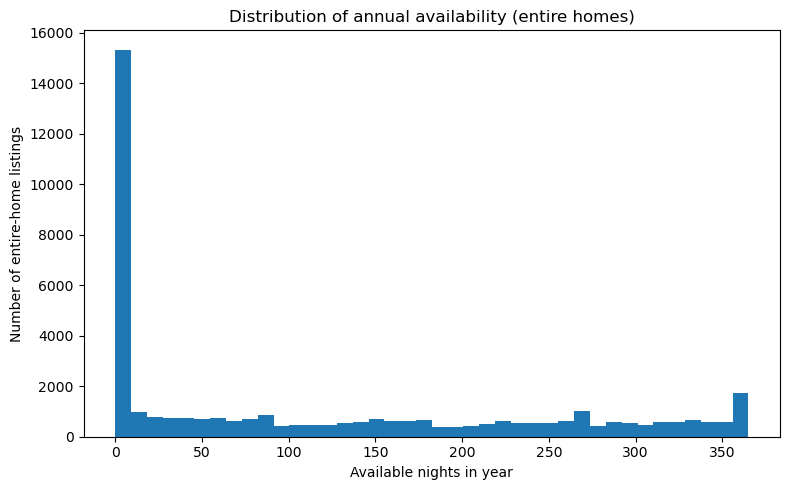

Using 'neighbourhood_cleansed' as area column for commercial STR plot.


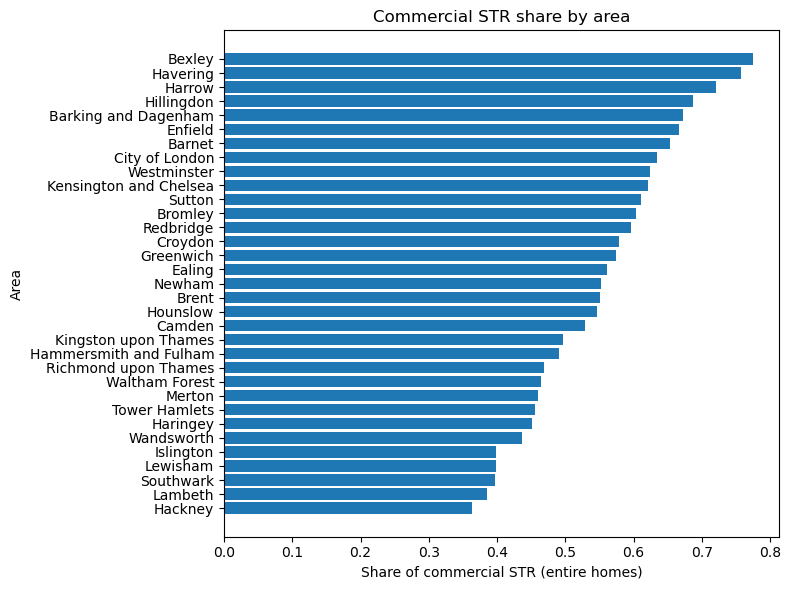

=== Commercialisation analysis done. ===
['neighbourhood_cleansed', 'neighbourhood_group_cleansed']
['Private room' 'Entire home/apt' nan 'Hotel room' 'Shared room']
is_entire_home
False    53368
True     40112
Name: count, dtype: int64
count    93480.000000
mean       124.264014
std        127.745448
min          0.000000
25%          0.000000
50%         81.000000
75%        243.000000
max        365.000000
Name: available_nights, dtype: float64
commercial_STR
True     50889
False    42591
Name: count, dtype: int64


In [23]:
results = run_commercial_analysis(load_rent=False, load_stock=False)
df = results["merged"]

print([col for col in df.columns if "neigh" in col.lower()])
print(df["room_type"].unique())
print(df["is_entire_home"].value_counts())
print(df["available_nights"].describe())
print(df["commercial_STR"].value_counts())